# Homework 3: z500 Composites With Hurricane Activity 

I've changed my project to using UFS P7 Reforecast data (z500, TS, and Precip) for August September and October looking at the Southeast region of the United States, and seeing if I can use that data to predict hurricane activity (or something like that).

z500 is the 500 hPa geopotential height and measured in meters, which can show places of low and high pressure on contour maps, which is useful when locating potential storms. 

TS is the surface temperature and measured in kelvin. It is useful when looking at the ocean surface temperature especially since the ocean has a high heat capacity and stays warmer longer than the land surface. Since tropical storms form in warmer waters, the surface temperature can help indicate where tropical storms might occur or move toward. 

Precip is the precipitation and measured in mm/day. It is useful to locate areas of heavy precipitation in the case of storm identification.

In [51]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

# Importing the Index

For this assignment, I've chosen the Hurricane Activity Index (HAI), which I found on https://psl.noaa.gov/data/climateindices/list/ when reading information about the indices. HAI gives the monthly totals of Atlantic hurricanes and named storms and was updated to 2016. 

Since my dataset is from 2011-2017, and the index goes till 2016, I will look at 2011-2016 for both.
EDIT: to clarify, I originally had 2011 to 2017, but when I saw that the index only went to 2016, I changed my dataset to match that.

HAI was imported and downloaded using the directions from the notebook supplied in the assignment directions.

In [52]:
path='/home/ldoyle4/'
file='hurricane.data'
index_name='ha'

df=pd.read_table(path+file,skiprows=64,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(6).index,inplace=True)

In [53]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-31'
print(start_date)
print(end_date)

2011-1-01
2016-12-31


In [54]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
      

In [55]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [56]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='ha')
ds_index

<xarray.Dataset>
Dimensions:  (time: 72)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2016-12-01
Data variables:
    ha       (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 6.0 3.5 15.5 1.5 0.0

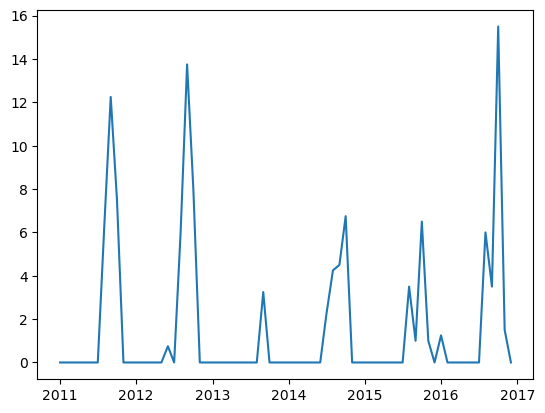

In [57]:
plt.plot(ds_index['time'],ds_index['ha'])

According to the index, there were 15.5 storms in October 2016. I don't believe this is accurate, and am not sure how to correct this error. I may have to do it manually, by finding out how many storms there were and editing the data file with a text editor.

# z500 Data 

In [58]:
file='/scratch/ldoyle4/subset/z500.nc'
ds_z500 = xr.open_dataset(file)
ds_z500

<xarray.Dataset>
Dimensions:    (time: 558, latitude: 53, longitude: 89)
Coordinates:
  * time       (time) datetime64[ns] 2011-08-01 2011-08-02 ... 2016-10-31
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
Data variables:
    z500       (time, latitude, longitude) float64 ...
Attributes:
    history:                   Mon Oct 10 18:35:55 2022: ncatted -a calendar,...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [59]:
#resample the data from daily to monthly, since the index is monthly
z500_mon1 = ds_z500.resample(time="MS").mean()

In [60]:
z500_mon1

<xarray.Dataset>
Dimensions:    (time: 63, latitude: 53, longitude: 89)
Coordinates:
  * time       (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
Data variables:
    z500       (time, latitude, longitude) float64 5.913e+03 ... 5.871e+03

Since we've resampled the data, the months now span a yearly range, which we don't want, since we only want August through October for each year. So to fix that, I wrote a line that selects the 8th, 9th, and 10th months of every year. 

I'm not sure if this is the right approach, but it's the one that didn't give me an error so it's the one I went with. 

In [61]:
def is_ASO(month):
    return (month >= 8) & (month <= 10)
z500_monthly = z500_mon1.sel(time=is_ASO(z500_mon1['time.month']))

In [62]:
z500_monthly

<xarray.Dataset>
Dimensions:    (time: 18, latitude: 53, longitude: 89)
Coordinates:
  * time       (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
Data variables:
    z500       (time, latitude, longitude) float64 5.913e+03 ... 5.871e+03

I've also selected the 8th, 9th, and 10th months from the index to match with the dataset.

In [63]:
def is_ASO(month):
    return (month >= 8) & (month <= 10)
ha_index = ds_index.sel(time=is_ASO(ds_index['time.month']))

In [64]:
ha_index

<xarray.Dataset>
Dimensions:  (time: 18)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
Data variables:
    ha       (time) float32 6.25 12.25 7.5 6.0 13.75 ... 1.0 6.5 6.0 3.5 15.5

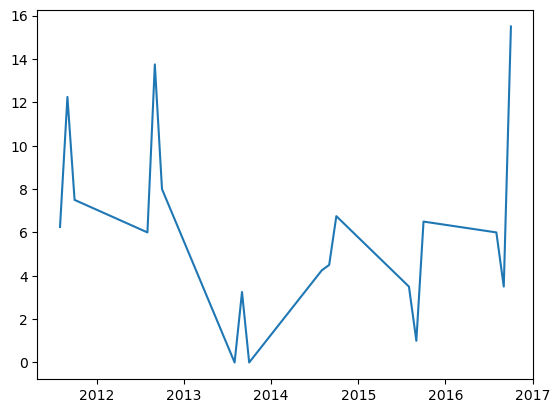

In [65]:
plt.plot(ha_index['time'],ha_index['ha'])

We see from the plot that we have some spikes in activity over time (until I fix October 2016, that will end up being the highest). 

As a general observation, and from the tropical storm and hurricane frequency plot with a climatology from 1851-2017 (Landsea, Chris (contributor from the NHC). "Total and Average Number of Tropical Cylones by Month (1851-2017)". aoml.noaa.gov. National Oceanic and Atmospheric Administration, Atlantic Oceanographic and Meteorological Laboratory. Archived from the original on September 1, 2018.) we see that September is the most active month, with an average of 6 storms, Augsut is the 2nd most active month, with an average of 4 storms, and October is the third most active month, with an average of 3 storms. This is why I have chosen August, September, and October as the months of investigation for my dataset. 

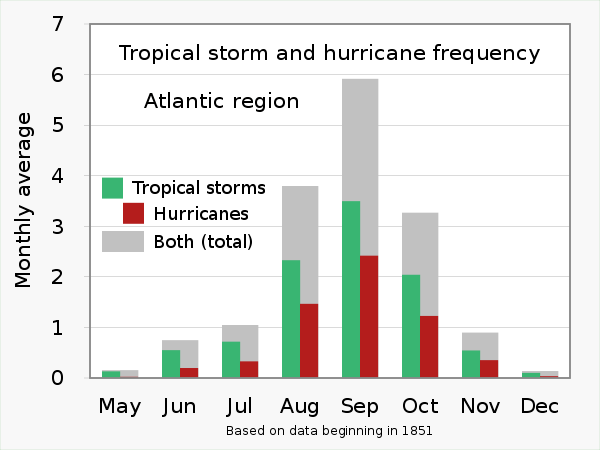

For August, September, and October, the composite I am making is looking at the 3 largest and 3 smallest valued years for HAI for each month. 

To do this, I need to find the month with the most storms and the month with the least storms for each year. 

We can just look at the data and do this by hand.


August: 6.25=2011, 6=2012, 0=2013, 4.25=2014, 3.5=2015, 6=2016

September: 12.25=2011, 13.37=2012, 3.25=2013, 4.5=2014, 1=2015, 3.5=2016

October: 7.5=2011, 8=2012, 0=2013, 6.75=2014, 6.5=2015, 15.5=2016

For August: 
* 3 largest years: 2011, 2012, 2016
* 3 smallest years: 2013, 2014, 2015

For September:
* 3 largest years: 2012, 2011, 2014
* 3 smallest years: 2015, 2013, 2016

For October: 
* 3 largest years: 2016, 2012, 2011
* 3 smallest years: 2013, 2014, 2015

Interestingly, August and October match up in terms of years.

I guess I should add these up now, if I'm interpreting this correctly:

August:
* largest number of storms total: 18.25
* smallest number of storms total: 7.75

September:
* largest number of storms total: 30.12
* smallest number of storms total: 7.75

October: 
* largest number of storms total: 31
* smallest number of storms total: 13.25




In [66]:
august1=ha_index['ha'].where(ha_index['ha']==6.25)
august2=ha_index['ha'].where(ha_index['ha']==6)
print(august1)
print(august2)
august = august1.combine_first(august2)
august_high = august.dropna(dim='time')
print(august_high)

<xarray.DataArray 'ha' (time: 18)>
array([6.25,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
<xarray.DataArray 'ha' (time: 18)>
array([nan, nan, nan,  6., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  6., nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
<xarray.DataArray 'ha' (time: 3)>
array([6.25, 6.  , 6.  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2012-08-01 2016-08-01


In [67]:
september1=ha_index['ha'].where(ha_index['ha']==13.75)
september2=ha_index['ha'].where(ha_index['ha']==12.25)
september3=ha_index['ha'].where(ha_index['ha']==4.5)

print(september1)

september4 = september1.combine_first(september2)
september4

september = september4.combine_first(september3)

print(september)

september_high = september.dropna(dim='time')
print(september_high)

<xarray.DataArray 'ha' (time: 18)>
array([  nan,   nan,   nan,   nan, 13.75,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
<xarray.DataArray 'ha' (time: 18)>
array([  nan, 12.25,   nan,   nan, 13.75,   nan,   nan,   nan,   nan,
         nan,  4.5 ,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
<xarray.DataArray 'ha' (time: 3)>
array([12.25, 13.75,  4.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-01 2012-09-01 2014-09-01


In [68]:
october1=ha_index['ha'].where(ha_index['ha']==15.5)
october2=ha_index['ha'].where(ha_index['ha']==8)
october3=ha_index['ha'].where(ha_index['ha']==7.5)
october4 = october1.combine_first(october2)
print(october4)

october = october4.combine_first(october3)

october_high = october.dropna(dim='time')
print(october_high)

<xarray.DataArray 'ha' (time: 18)>
array([ nan,  nan,  nan,  nan,  nan,  8. ,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan, 15.5], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
<xarray.DataArray 'ha' (time: 3)>
array([ 7.5,  8. , 15.5], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2012-10-01 2016-10-01


In [69]:
print('August: ',august_high.count(dim='time').values)
print('September: ',september_high.count(dim='time').values)
print('October: ',october_high.count(dim='time').values)

August:  3
September:  3
October:  3


In [70]:
august1l=ha_index['ha'].where(ha_index['ha']==0)
august2l=ha_index['ha'].where(ha_index['ha']==4.25)
august3l=ha_index['ha'].where(ha_index['ha']==3.5)

august4l = august1l.combine_first(august2l)
augustl = august4l.combine_first(august3l)

august_lowl = augustl.dropna(dim='time')
august_lowl = august_lowl.drop_sel(time='2013-10-01')
august_lowl = august_lowl.drop_sel(time='2016-09-01')
print(august_lowl)

<xarray.DataArray 'ha' (time: 3)>
array([0.  , 4.25, 3.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-08-01 2014-08-01 2015-08-01


In [71]:
september1l=ha_index['ha'].where(ha_index['ha']==3.25)
september2l=ha_index['ha'].where(ha_index['ha']==1)
september3l=ha_index['ha'].where(ha_index['ha']==3.5)

september4l = september1l.combine_first(september2l)
septemberl = september4l.combine_first(september3l)

september_lowl = septemberl.dropna(dim='time')
september_lowl = september_lowl.drop_sel(time='2015-08-01')
print(september_lowl)

<xarray.DataArray 'ha' (time: 3)>
array([3.25, 1.  , 3.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-09-01 2015-09-01 2016-09-01


In [72]:
october1l=ha_index['ha'].where(ha_index['ha']==0)
october2l=ha_index['ha'].where(ha_index['ha']==6.75)
october3l=ha_index['ha'].where(ha_index['ha']==6.5)

october4l = october1l.combine_first(october2l)
octoberl = october4l.combine_first(october3l)

october_lowl = octoberl.dropna(dim='time')
october_lowl = october_lowl.drop_sel(time='2013-08-01')

print(october_lowl)

<xarray.DataArray 'ha' (time: 3)>
array([0.  , 6.75, 6.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-10-01 2014-10-01 2015-10-01


# z500 Climatology

In [73]:
clim = z500_monthly['z500'].groupby('time.month').mean()
clim

<xarray.DataArray 'z500' (month: 3, latitude: 53, longitude: 89)>
array([[[5919.15555958, 5918.81867899, 5918.50028811, ...,
         5889.03978967, 5888.96925403, 5888.90429622],
        [5919.90791895, 5919.593687  , 5919.28620894, ...,
         5890.88800574, 5890.83446544, 5890.80143885],
        [5920.51660616, 5920.20618004, 5919.89895006, ...,
         5892.69338694, 5892.65327109, 5892.63664065],
        ...,
        [5903.9181151 , 5903.94145941, 5903.97233729, ...,
         5912.25340944, 5912.38354689, 5912.51860194],
        [5903.18031426, 5903.22743865, 5903.25926684, ...,
         5911.80795846, 5911.93252137, 5912.05604077],
        [5902.40736504, 5902.47467697, 5902.51967301, ...,
         5911.34631545, 5911.46129255, 5911.58079873]],

       [[5879.05636664, 5878.73282471, 5878.42056953, ...,
         5867.05547824, 5867.09493069, 5867.15431858],
        [5880.26312527, 5879.93728841, 5879.64087796, ...,
         5868.54705268, 5868.58555976, 5868.64156969],
        [5881.395617  , 5881.05454305, 5880.71825901, ...,
         5869.96935221, 5870.00359429, 5870.05380113],
...
        [5888.92215983, 5889.00751275, 5889.0746738 , ...,
         5895.33088311, 5895.50784912, 5895.67788018],
        [5888.71493666, 5888.84934896, 5888.95492757, ...,
         5895.34182197, 5895.51477119, 5895.67837321],
        [5888.5301534 , 5888.69568346, 5888.81560059, ...,
         5895.3115682 , 5895.48759901, 5895.64640774]],

       [[5781.67748833, 5781.28637632, 5780.92348671, ...,
         5794.40885099, 5795.17200279, 5795.95991262],
        [5785.40228844, 5785.02979533, 5784.70218786, ...,
         5797.74884987, 5798.5136617 , 5799.2866567 ],
        [5789.04806137, 5788.66061783, 5788.2907149 , ...,
         5801.01648458, 5801.76888021, 5802.51876132],
        ...,
        [5876.4505469 , 5876.38864072, 5876.32098961, ...,
         5875.39335569, 5875.70093028, 5875.97319285],
        [5876.83447266, 5876.77076976, 5876.70122782, ...,
         5875.73920949, 5876.06580607, 5876.34634717],
        [5877.16407776, 5877.09659131, 5877.03557205, ...,
         5876.17476209, 5876.44957987, 5876.71496518]]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
  * month      (month) int64 8 9 10

In [74]:
clim[0,:,:]

<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[5919.15555958, 5918.81867899, 5918.50028811, ..., 5889.03978967,
        5888.96925403, 5888.90429622],
       [5919.90791895, 5919.593687  , 5919.28620894, ..., 5890.88800574,
        5890.83446544, 5890.80143885],
       [5920.51660616, 5920.20618004, 5919.89895006, ..., 5892.69338694,
        5892.65327109, 5892.63664065],
       ...,
       [5903.9181151 , 5903.94145941, 5903.97233729, ..., 5912.25340944,
        5912.38354689, 5912.51860194],
       [5903.18031426, 5903.22743865, 5903.25926684, ..., 5911.80795846,
        5911.93252137, 5912.05604077],
       [5902.40736504, 5902.47467697, 5902.51967301, ..., 5911.34631545,
        5911.46129255, 5911.58079873]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      int64 8

I made a contour plot of the first time stamp just to see what it looks like.

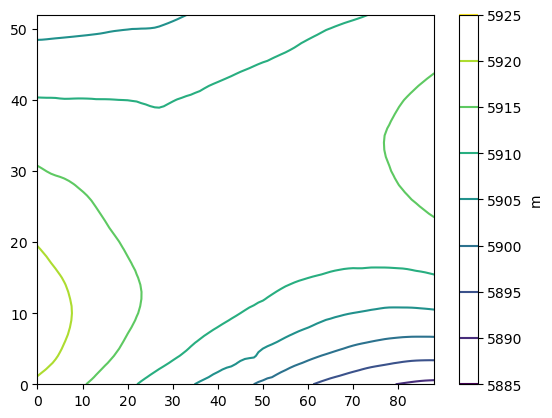

In [75]:
cs = plt.contour(clim[0,:,:])
plt.colorbar(cs, label='m')

# z500 Anomalies

In [76]:
ds_anoms = z500_monthly['z500'].groupby('time.month')-clim

In [77]:
ds_anoms

<xarray.DataArray 'z500' (time: 18, latitude: 53, longitude: 89)>
array([[[ -6.50283387,  -6.54722218,  -6.57627491, ...,  -7.81025811,
          -7.88375756,  -8.03445467],
        [ -6.03212746,  -6.08688256,  -6.1223197 , ...,  -7.19993476,
          -7.30558203,  -7.46980926],
        [ -5.61482551,  -5.61342629,  -5.62684352, ...,  -6.71226058,
          -6.83083614,  -6.98066236],
        ...,
        [ -5.97650015,  -6.06580968,  -6.16473979, ...,  -2.16776333,
          -2.30725295,  -2.44489904],
        [ -5.96161545,  -6.08709717,  -6.19103348, ...,  -2.43341524,
          -2.55718666,  -2.69313361],
        [ -5.93991844,  -6.05545602,  -6.14580314, ...,  -2.7119436 ,
          -2.82385713,  -2.94949833]],

       [[ -4.95798611,  -4.66493734,  -4.35005358, ..., -26.75976698,
         -27.00154283, -27.23291965],
        [ -5.38725043,  -5.1129069 ,  -4.81896634, ..., -27.1426378 ,
         -27.38767565, -27.6216885 ],
        [ -5.79942559,  -5.54066366,  -5.2522149 , ..., -27.50761312,
         -27.77336561, -27.97926093],
...
        [  8.99088135,   8.61000841,   8.24367337, ...,   0.51514553,
           0.75084229,   0.97163561],
        [  8.89491848,   8.45952555,   8.06575521, ...,   0.33371107,
           0.53860609,   0.73280436],
        [  8.73300985,   8.2888421 ,   7.89711507, ...,   0.12446696,
           0.32144233,   0.46095717]],

       [[ 30.57773399,  30.04526583,  29.52705956, ..., -37.75251706,
         -37.68785667, -37.52906545],
        [ 30.1171627 ,  29.5851148 ,  29.02899806, ..., -37.25235176,
         -37.20124181, -37.03049978],
        [ 29.6104393 ,  29.07447052,  28.49216779, ..., -36.59719213,
         -36.56644567, -36.45213763],
        ...,
        [  2.3361009 ,   2.27879397,   2.19394875, ...,  -6.3476518 ,
          -6.24005763,  -6.08687083],
        [  2.02481842,   1.96493657,   1.89728673, ...,  -6.22836431,
          -6.12744395,  -5.9757913 ],
        [  1.73443604,   1.6789786 ,   1.61264801, ...,  -6.23028882,
          -6.0880839 ,  -5.93160947]]])
Coordinates:
  * time       (time) datetime64[ns] 2011-08-01 2011-09-01 ... 2016-10-01
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      (time) int64 8 9 10 8 9 10 8 9 10 8 9 10 8 9 10 8 9 10

I made a contour plot of the first time stamp just to see what it looks like.

''

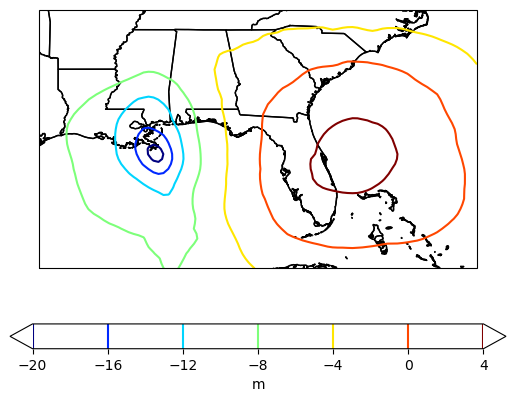

In [78]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

cs=ax.contour(ds_anoms['longitude'],ds_anoms['latitude'],ds_anoms[0,:,:], 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 
;

# Composites:

## Plotting Monthly z500 Anomalies Corresponding With Highest Hurricane Activity

In [79]:
august_z500 = ds_anoms.sel(time=august_high.dropna(dim='time')['time']).mean(dim='time')
september_z500 = ds_anoms.sel(time=september_high.dropna(dim='time')['time']).mean(dim='time')
october_z500 = ds_anoms.sel(time=october_high.dropna(dim='time')['time']).mean(dim='time')

comp = [august_z500,september_z500,october_z500]
comp

[<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
 array([[ 8.49931614,  8.502488  ,  8.49216059, ...,  2.88654418,
          2.66234958,  2.44412527],
        [ 8.14737234,  8.12889312,  8.11098423, ...,  2.5311614 ,
          2.30927826,  2.09675844],
        [ 7.77089437,  7.76261853,  7.747491  , ...,  2.17551873,
          1.96875328,  1.77667761],
        ...,
        [-5.00469314, -5.02044284, -5.05036779, ..., -1.43214531,
         -1.49049886, -1.54657048],
        [-5.10427364, -5.14240421, -5.16138745, ..., -1.46092306,
         -1.51668557, -1.5653063 ],
        [-5.20952582, -5.2330762 , -5.25528578, ..., -1.48482193,
         -1.54038755, -1.58765305]])
 Coordinates:
   * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
   * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0,
 <xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
 array([[-2.30232069, -2.25299479, -2.20014581, ..., -9.2165568 ,
         -9.42360908

I've made the decision to make the plots separate, instead of as a loop, because I could not figure out how to add the colorbar into the loop without it giving the same bounds for each colorbar.

''

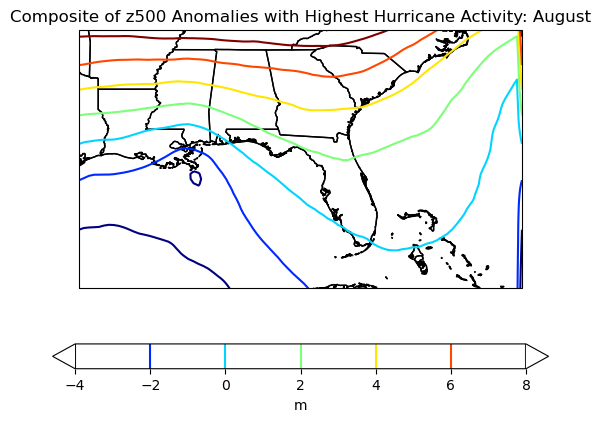

In [80]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= august_z500
data, lons = add_cyclic_point(data, coord=august_z500['longitude'])

cs=ax.contour(lons, august_z500['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

#ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
#lon_formatter = cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

#ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
#lat_formatter = cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Highest Hurricane Activity: August')
;

''

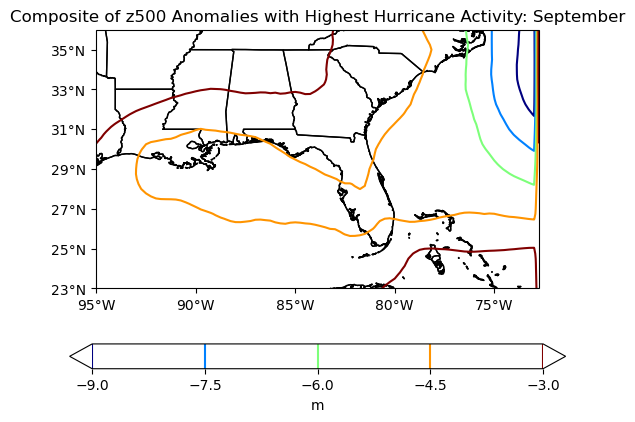

In [81]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= september_z500
data, lons = add_cyclic_point(data, coord=september_z500['longitude'])

cs=ax.contour(lons, september_z500['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Highest Hurricane Activity: September')
;

''

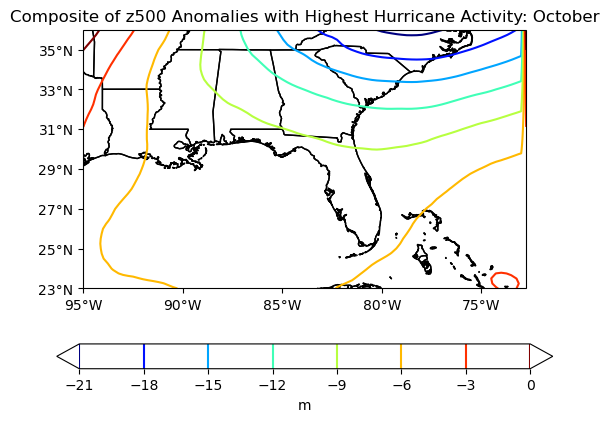

In [82]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= october_z500
data, lons = add_cyclic_point(data, coord=october_z500['longitude'])

cs=ax.contour(lons, october_z500['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Highest Hurricane Activity: October')
;

## Plotting Monthly z500 Anomalies Corresponding With Lowest Hurricane Activity

In [83]:
august_z500l = ds_anoms.sel(time=august_lowl.dropna(dim='time')['time']).mean(dim='time')
september_z500l = ds_anoms.sel(time=september_lowl.dropna(dim='time')['time']).mean(dim='time')
october_z500l = ds_anoms.sel(time=october_lowl.dropna(dim='time')['time']).mean(dim='time')

compl = [august_z500l,september_z500l,october_z500l]
compl

[<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
 array([[-8.49931614, -8.502488  , -8.49216059, ..., -2.88654418,
         -2.66234958, -2.44412527],
        [-8.14737234, -8.12889312, -8.11098423, ..., -2.5311614 ,
         -2.30927826, -2.09675844],
        [-7.77089437, -7.76261853, -7.747491  , ..., -2.17551873,
         -1.96875328, -1.77667761],
        ...,
        [ 5.00469314,  5.02044284,  5.05036779, ...,  1.43214531,
          1.49049886,  1.54657048],
        [ 5.10427364,  5.14240421,  5.16138745, ...,  1.46092306,
          1.51668557,  1.5653063 ],
        [ 5.20952582,  5.2330762 ,  5.25528578, ...,  1.48482193,
          1.54038755,  1.58765305]])
 Coordinates:
   * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
   * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0,
 <xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
 array([[2.30232069, 2.25299479, 2.20014581, ..., 9.2165568 , 9.42360908,
         9.6

''

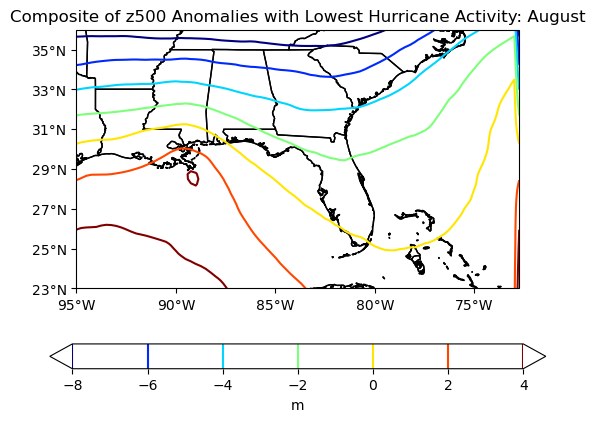

In [84]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= august_z500l
data, lons = add_cyclic_point(data, coord=august_z500l['longitude'])

cs=ax.contour(lons, august_z500l['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Lowest Hurricane Activity: August')
;

''

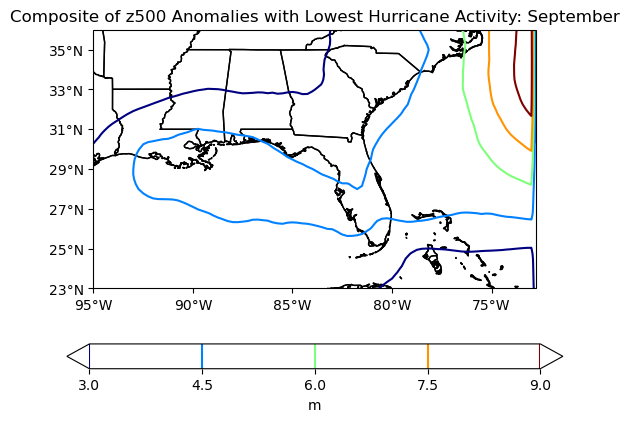

In [85]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= september_z500l
data, lons = add_cyclic_point(data, coord=september_z500l['longitude'])

cs=ax.contour(lons, september_z500l['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Lowest Hurricane Activity: September')
;

''

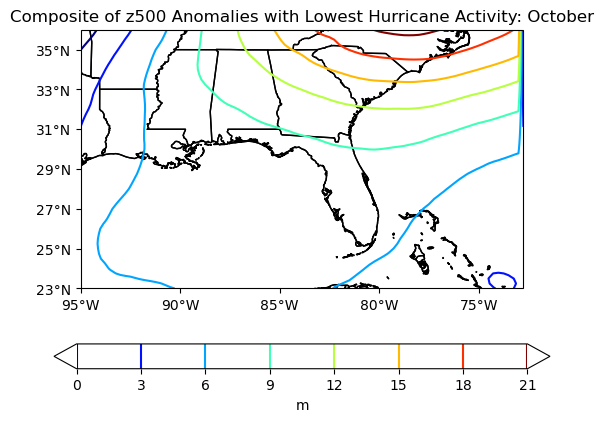

In [86]:
fig = plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())

data= october_z500l
data, lons = add_cyclic_point(data, coord=october_z500l['longitude'])

cs=ax.contour(lons, october_z500l['latitude'], data, 
            transform = ccrs.PlateCarree(),cmap='jet', extend='both')

ax.set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
        
ax.add_feature(feature.STATES)

cbar = plt.colorbar(cs, orientation='horizontal',label='m') 

plt.title('Composite of z500 Anomalies with Lowest Hurricane Activity: October')
;

# Composites Using Alternative Averaging Method:

Since I was having errors with my anomalies, I also included an alternative approach, which at least gave me different values. 

Just to recall, these are the dates and their corresponding index value in the array:

august high: 2011-08-01 = 0, 2012-08-01 = 3, 2016-08-01 = 15

september high: 2011-09-01 = 1, 2012-09-01 = 4, 2014-09-01 = 10

october high: 2011-10-01 = 2, 2012-10-01 = 5, 2016-10-01 = 17

august low: 2013-08-01 = 6, 2014-08-01 = 9, 2015-08-01 = 12

september low: 2013-09-01 = 7, 2015-09-01 = 13, 2016-09-01 = 16

october low: 2013-10-01 = 8, 2014-10-01 = 11, 2015-10-01 = 14

## High Hurricane Activity

In [87]:
a1 = ds_anoms[0,:,:]
a2 = ds_anoms[3,:,:]
a3 = ds_anoms[15,:,:]

s1 = ds_anoms[1,:,:]
s2 = ds_anoms[4,:,:]
s3 = ds_anoms[10,:,:]

o1 = ds_anoms[2,:,:]
o2 = ds_anoms[5,:,:]
o3 = ds_anoms[17,:,:]

In [88]:
a4 = (a1 + a2) / 2
print(a4)

s4 = (s1 + s2) / 2
print(s4)

o4 = (o1 + o2) / 2
print(o4)

<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[ 2.94311852,  2.9612873 ,  2.94579422, ...,  1.13083509,
         0.94443832,  0.73446032],
       [ 2.90380137,  2.87404706,  2.8421539 , ...,  0.99146952,
         0.7994516 ,  0.59852846],
       [ 2.79175133,  2.78121128,  2.76723095, ...,  0.84229303,
         0.65355855,  0.47091511],
       ...,
       [-8.2337909 , -8.24527076, -8.28171269, ..., -2.74168084,
        -2.79027533, -2.83919402],
       [-8.27301485, -8.31964308, -8.3467125 , ..., -2.872575  ,
        -2.91198205, -2.95575214],
       [-8.30730479, -8.32985827, -8.35027879, ..., -3.00690485,
        -3.04469611, -3.08381111]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      int64 8
<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[  4.41596612,   4.50985107,   4.58783095, ..., -21.41623874,
        -21.8

In [89]:
a_high = (a4 + a3) / 2
print(a_high)

s_high = (s4 + s3) / 2
print(s_high)

o_high = (o4 + o3) / 2
print(o_high)

comp_high = [a_high, s_high, o_high]

<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[11.27741496, 11.27308835, 11.26534378, ...,  3.76439872,
         3.52130521,  3.29895774],
       [10.76915782, 10.75631615, 10.74539939, ...,  3.30100734,
         3.06419159,  2.84587343],
       [10.26046589, 10.25332215, 10.23762102, ...,  2.84213158,
         2.62635065,  2.42955887],
       ...,
       [-3.39014427, -3.40802888, -3.43469534, ..., -0.77737755,
        -0.84061063, -0.90025871],
       [-3.51990304, -3.55378477, -3.56872493, ..., -0.75509709,
        -0.81903732, -0.87008339],
       [-3.66063633, -3.68468516, -3.70778927, ..., -0.72378048,
        -0.78823328, -0.83957401]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      int64 8
    time       datetime64[ns] 2016-08-01
<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[-5.6614641 , -5.63441772, -5.5941

Text(0.5, 0.98, 'Composites: z500 Monthly Anomalies of Highest Hurricane Activity')

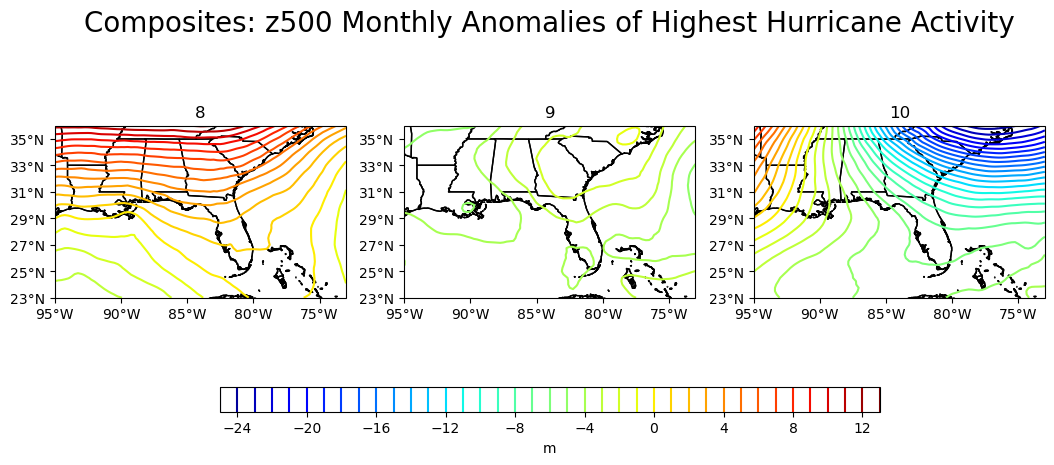

In [90]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,5))

# We will flatten it into a 1-D array
axs=axs.flatten()
clevs = np.arange(-25,14,1)
#Loop over all of the seasons and plot
for i in range(0,3):

        # Select the season
        data=comp_high[i]

        # Contour plot
        cs=axs[i].contour(data['longitude'],data['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='jet')

        axs[i].set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(data['time.month'].values)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        #ax.add_feature(cfeature.COASTLINE)
        axs[i].add_feature(feature.STATES)
        
        #.colorbar(cs)
        #axs[i].colorbar(cs, orientation='horizontal',label='K')
       
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.05])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m')

# Add a big title at the top
plt.suptitle('Composites: z500 Monthly Anomalies of Highest Hurricane Activity', fontsize=20)

## Low Hurricane Activity

In [94]:
a5 = ds_anoms[6,:,:]
a6 = ds_anoms[9,:,:]
a7 = ds_anoms[12,:,:]

s5 = ds_anoms[7,:,:]
s6 = ds_anoms[13,:,:]
s7 = ds_anoms[16,:,:]

o5 = ds_anoms[8,:,:]
o6 = ds_anoms[11,:,:]
o7 = ds_anoms[14,:,:]

In [95]:
a8 = (a5 + a6) / 2
print(a8)

s8 = (s5 + s6) / 2
print(s8)

o8 = (o5 + o6) / 2
print(o8)

<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[-17.62648125, -17.62371892, -17.59718438, ...,  -6.10240387,
         -5.8414661 ,  -5.59522994],
       [-17.21336053, -17.17251488, -17.14125242, ...,  -5.63134503,
         -5.37013556,  -5.11463387],
       [-16.764718  , -16.74355915, -16.71988079, ...,  -5.17188484,
         -4.91621842,  -4.6482078 ],
       ...,
       [  3.98707958,   3.98844073,   3.99955897, ...,   1.3412364 ,
          1.39278683,   1.44095538],
       [  4.10400128,   4.11670906,   4.11543389, ...,   1.35481443,
          1.39316222,   1.43221882],
       [  4.21258873,   4.20584336,   4.20166803, ...,   1.36404321,
          1.40011826,   1.43658447]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      int64 8
<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[-3.67450833, -3.77576701, -3.86809557,

In [96]:
a_low = (a8 + a7) / 2
print(a_low)

s_low = (s8 + s7) / 2
print(s_low)

o_low = (o8 + o7) / 2
print(o_low)

comp_low = [a_low, s_low, o_low]

<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[-3.93573359, -3.94187255, -3.9396487 , ..., -1.27861433,
        -1.07279131, -0.86857293],
       [-3.61437824, -3.60708224, -3.59585013, ..., -0.98106959,
        -0.77884961, -0.58782073],
       [-3.27398255, -3.27214821, -3.2612961 , ..., -0.67733568,
        -0.49502071, -0.34091252],
       ...,
       [ 5.51349993,  5.53644389,  5.57577219, ...,  1.47759977,
         1.53935488,  1.59937803],
       [ 5.60440982,  5.65525178,  5.68436424, ...,  1.51397738,
         1.57844724,  1.63185005],
       [ 5.70799436,  5.74669262,  5.78209465, ...,  1.5452113 ,
         1.6105222 ,  1.66318733]])
Coordinates:
  * latitude   (latitude) float64 36.0 35.75 35.5 35.25 ... 23.5 23.25 23.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 286.5 286.8 287.0
    month      int64 8
    time       datetime64[ns] 2015-08-01
<xarray.DataArray 'z500' (latitude: 53, longitude: 89)>
array([[ 5.2907352 ,  5.26737569,  5.2342

Text(0.5, 0.98, 'Composites: z500 Monthly Anomalies of Lowest Hurricane Activity')

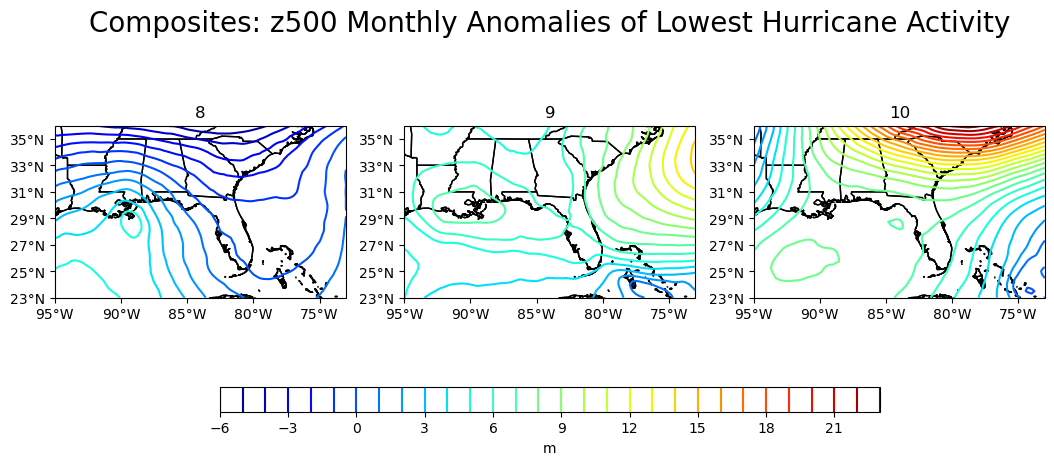

In [97]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,5))

# We will flatten it into a 1-D array
axs=axs.flatten()
clevs = np.arange(-6,24,1)
#Loop over all of the seasons and plot
for i in range(0,3):

        # Select the season
        data=comp_low[i]

        # Contour plot
        cs=axs[i].contour(data['longitude'],data['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='jet')

        axs[i].set_xticks(np.arange(-95,-72,5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(23,37,2), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(data['time.month'].values)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        #ax.add_feature(cfeature.COASTLINE)
        axs[i].add_feature(feature.STATES)
        
        #.colorbar(cs)
        #axs[i].colorbar(cs, orientation='horizontal',label='K')
       
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.05])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m')

# Add a big title at the top
plt.suptitle('Composites: z500 Monthly Anomalies of Lowest Hurricane Activity', fontsize=20)

Hurricanes favor warm water, and high relative humidity, and are low pressure systems. So, high anomalies in surface temperature and precipitation, and low anomalies in z500 can indicate conditions favorable for hurricane/tropical cyclone formation/places where tropical storms can migrate to (a big reason why many hurricanes have trajectories through warmer tropical/subtropical waters like the Caribbean Sea and the Gulf of Mexico). 

Using the composites from the alternative averaging method, we can make some observations:

Based on the z500 geopotential height anomalies corresponding with high hurricane activity, we see that for August, the height contours were lower in the atmosphere over Florida and into the water and higher over the continent, which could indicate a storm in the Caribbean. For September, the anomalies have a very distinct shape that could indicate locations of low pressure around Louisiana, the Bahamas, and North Carolina, meaning that those are regions indicating storms. For October, the low z500 anomalies are up near the midlatitudes.

Based on the z500 anomalies corresponding with low hurricane activity, we that for August, the low height anomalies were more over the continent, and the higher height anomalies were over the gulf. And since we know these are anomalies for low hurricane activity months, this makes sense. For September, all the height anomalies are positive, with the highest being out in the Atlantic. For October, again, all the height anomalies are positive, with the highest being in the mid latitudes over the continent. 